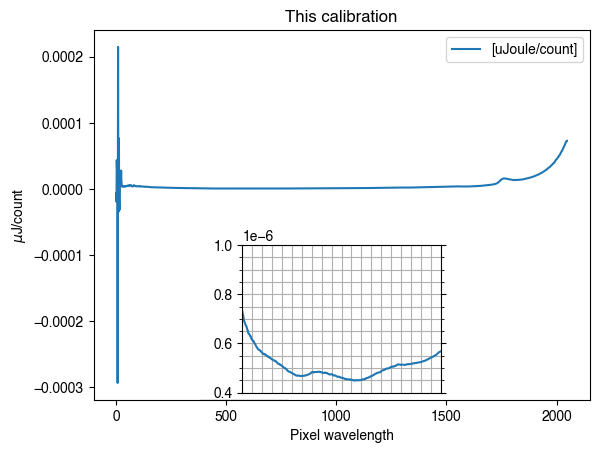

In [28]:
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import (
    mark_inset, 
    inset_axes
)
data = pd.read_table('../../data/oo_jaz_CC/oo_jaz_cc(uJoule_only)_OOIIrrad.cal', skiprows=7)
ax1 = data.plot(title='This calibration')
axins = inset_axes(ax1, '40%', '40%', loc='lower center')
data.plot(ax=axins, legend=False, xlabel='')

axins.set_xlim(380, 780)
axins.set_ylim((.4e-6, 1e-6))
axins.set_xticklabels([])
axins.minorticks_on()
axins.tick_params(which='both', bottom=False, right=True)
axins.grid(True, 'both')
ax1.set_ylabel('$\mu$J/count')
ax1.set_xlabel('Pixel wavelength')
ax1.indicate_inset_zoom(
    axins, 
    edgecolor="black",
    transform=ax1.get_xaxis_transform()
);

In [29]:
lamp_cc = pd.read_table('../../data/jaz/030410313_CC.LMP', header=None)
lamp_cc.columns = ['Wavelength', 'uJ/cm2']
lamp_cc = lamp_cc.squeeze()
lamp_cc

,Wavelength,uJ/cm2
0,300.0,0.22874
1,310.0,0.16599
2,320.0,0.16086
3,330.0,0.16554
4,340.0,0.13879
5,350.0,0.21906
6,360.0,0.32334
7,370.0,0.41326
8,380.0,0.56613
9,390.0,0.75291


In [30]:
lamp_fib = pd.read_table('../../data/jaz/030410313_FIB.LMP', header=None)
lamp_fib.columns = ['Wavelength', 'uJ/cm2']
lamp_fib = lamp_fib.squeeze()
lamp_fib

,Wavelength,uJ/cm2
0,300.0,0.001069
1,310.0,0.000580
2,320.0,0.000834
3,330.0,0.000760
4,340.0,0.001402
5,350.0,0.001677
6,360.0,0.002128
7,370.0,0.003398
8,380.0,0.004183
9,390.0,0.006029


<AxesSubplot: >

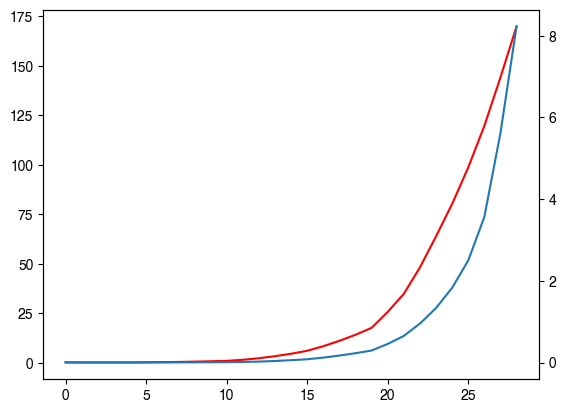

In [31]:
ax =lamp_cc['uJ/cm2'].plot(c='r')
lamp_fib['uJ/cm2'].plot(ax=ax.twinx())

Hit enter to obtain reference measurement: 


> Obtaining sample...
> Correcting for dark counts: False
> Correcting for nonlinearity: True
	> Integration time: 0.001 seconds
	> Maximum reported value: 3237
	> Integration time: 0.017204 seconds
	> Maximum reported value: 30329
	> Integration time: 0.031598 seconds
	> Maximum reported value: 53695
> Computing average of 3 scans
> Applying boxcar average (boxcar_width = 2)




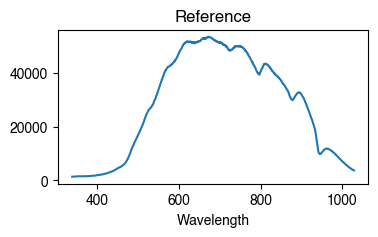

Now block all light and hit enter to obtain dark counts: 


> Obtaining sample...
> Correcting for dark counts: False
> Correcting for nonlinearity: True
	> Integration time: 0.032781 seconds
	> Maximum reported value: 1546
> Computing average of 3 scans
> Applying boxcar average (boxcar_width = 2)




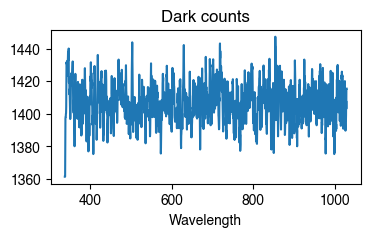

> Closing connection to spectrometer


In [155]:
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

from pyplr.oceanops import OceanOptics


# Load the HL-2000-CAL lamp calibration data for cosine corrector probe
lamp_file = pd.read_table('../../data/jaz/030410313_CC.LMP', header=None)
lamp_file.columns = ['Wavelength', 'uJ/cm2']
lamp_file = lamp_file.squeeze()

# Load JAZ calibrated wavelengths
cal_wls = pd.read_csv('../../data/jaz/jaz_Ar_1_calibrated_wavelengths.csv')
cal_wls = cal_wls.cal_wl

try:
    # Connect to JAZ
    oo = OceanOptics.from_serial_number('JAZA1505')

    # Perform reference measurement
    input('Hit enter to obtain reference measurement:')
    reference_counts, reference_info = oo.sample(
        correct_nonlinearity = True,
        correct_dark_counts = False,
        scans_to_average=3,
        boxcar_width=2,
        wavelengths=cal_wls
    )
    reference_counts.plot(figsize=(4, 2), title='Reference')
    plt.show()

    # Perform dark measurement
    input('Now block all light and hit enter to obtain dark counts:')
    dark_counts, dark_info = oo.sample(
        correct_nonlinearity = True,
        correct_dark_counts = False,
        integration_time = reference_info['integration_time'],
        scans_to_average=3,
        boxcar_width=2,
        wavelengths=cal_wls
    )
    dark_counts.plot(figsize=(4, 2), title='Dark counts')
    plt.show()

    # Resample lamp file to pixel wavelengths
    interp_func = interpolate.interp1d(lamp_file['Wavelength'], lamp_file['uJ/cm2'])
    wavelengths = cal_wls.values
    resampled_lamp_data = interp_func(wavelengths)     

    # Calculate scaling parameters
    integration_time = reference_info['integration_time'] / 1e6  # Microseconds to seconds
    collection_area = 0.1193985
    wavelength_spread = np.hstack(  # How many nanometers each pixel represents
        [(wavelengths[1] - wavelengths[0]),
         (wavelengths[2:] - wavelengths[:-2]) / 2,
         (wavelengths[-1] - wavelengths[-2])
        ]
    )

    # Make the calibration file. To do this we need to adapt the 
    # formula slightly, dividing the resampled lamp data by the
    # reference measurement (instead of multiplying the reference
    # measurement by the calibration file). 
    calibration_file = (
        resampled_lamp_data
        / ((reference_counts - dark_counts)
           / (integration_time
              * collection_area
              * wavelength_spread)
          )
    )

except KeyboardInterrupt:
    print('> Calibration terminated by user')

except Exception as e:
    print('> Something else went wrong')
    raise e

finally:
    oo.close()
    print('> Closing connection to spectrometer')



In [194]:
# Calculate scaling parameters
integration_time = reference_info['integration_time'] / 1e6  # Microseconds to seconds
fibre_diameter = 400 / 1e4  # Microns to cm
collection_area = np.pi * (fibre_diameter/2) ** 2  # cm2
collection_area = 0.1193985
wavelength_spread = np.hstack(  # How many nanometers each pixel represents
    [(wavelengths[1] - wavelengths[0]),
     (wavelengths[2:] - wavelengths[:-2]) / 2,
     (wavelengths[-1] - wavelengths[-2])
    ]
)

# Make the calibration file. To do this we need to adapt the 
# formula slightly, dividing the resampled lamp data by the
# reference measurement (instead of multiplying the reference
# measurement by the calibration file). 
calibration_file = (
    resampled_lamp_data
    / ((reference_counts - dark_counts)
       / (integration_time
          * collection_area
          * wavelength_spread)
      )
)

In [191]:
collection_area

0.0012566370614359172

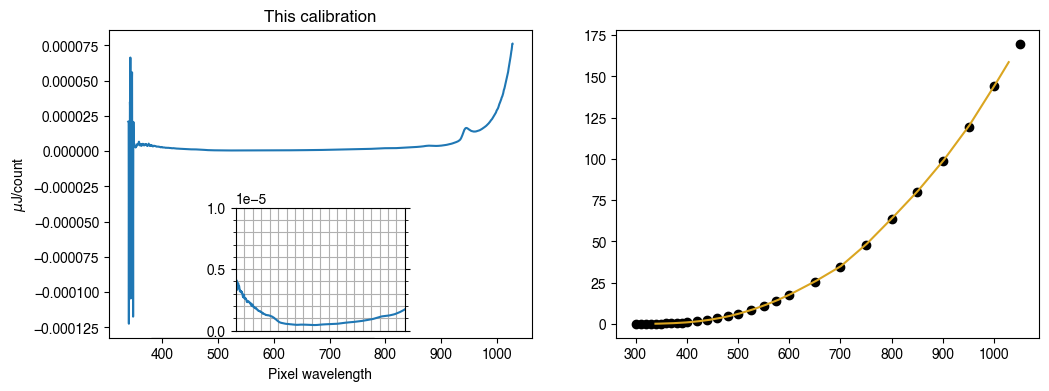

In [195]:
from mpl_toolkits.axes_grid1.inset_locator import (
    mark_inset, 
    inset_axes
)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot this calibration
calibration_file.plot(ax=ax1, title='This calibration')
axins = inset_axes(ax1, '40%', '40%', loc='lower center')
calibration_file.plot(ax=axins, legend=False, xlabel='')

axins.set_xlim(380, 780)
axins.set_ylim(.0, .00001)
axins.set_xticklabels([])
axins.minorticks_on()
axins.tick_params(which='both', bottom=False, right=True)
axins.grid(True, 'both')
ax1.set_ylabel('$\mu$J/count')
ax1.set_xlabel('Pixel wavelength')
ax1.indicate_inset_zoom(
    axins, 
    edgecolor="black",
    transform=ax1.get_xaxis_transform()
);

# Lamp data
ax2.scatter(lamp_file['Wavelength'], lamp_file['uJ/cm2'], c='k')

# This calibration
this_calibration_spectrum = (
    (reference_counts - dark_counts)
    * (calibration_file  # The calibration file we just made
       / (integration_time
          * 0.1193985
          * wavelength_spread)
      )
)
ax2.plot(this_calibration_spectrum, c='goldenrod')

In [4]:
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

from pyplr.oceanops import OceanOptics


# Load the HL-2000-CAL lamp calibration data for cosine corrector probe
lamp_file = pd.read_table('../../data/jazcal/030410313_CC.LMP', header=None)
lamp_file.columns = ['Wavelength', 'uJ/cm2']
lamp_file = lamp_file.squeeze()

# Load JAZ calibrated wavelengths
cal_wls = pd.read_csv('../../data/jazcal/jaz_Ar_1_calibrated_wavelengths.csv')
cal_wls = cal_wls.cal_wl

In [5]:
spectra = pd.read_csv('../../data/raw_CRT_spectra.csv', index_col='Wavelength')
spectra.index = cal_wls
info = pd.read_csv('../../data/raw_CRT_spectra_info.csv', index_col='measure').T
info.integration_time = info.integration_time.astype('int')
info

measure,board_temp,micro_temp,integration_time,scans_averaged,boxcar_width,max_reported,upper_bound,lower_bound,model,serial,obtained,sample_id
red,NaN,NaN,272151,3,0,56127.38994,58981.5,52428,JAZ,JAZA1505,58:37.1,red
green,NaN,NaN,1222983,3,0,53990.60582,58981.5,52428,JAZ,JAZA1505,59:13.3,green
blue,NaN,NaN,2280499,3,0,53767.84362,58981.5,52428,JAZ,JAZA1505,59:44.6,blue
white,NaN,NaN,259351,3,0,58228.77273,58981.5,52428,JAZ,JAZA1505,00:16.4,white


In [6]:
processed = []
for s in ['red', 'green', 'blue', 'white']:
    new = (
    (spectra[s])
    * (calibration_file  # The calibration file we just made
       / (info.loc[s, 'integration_time'])
          * collection_area
          * wavelength_spread)
      )

    processed.append(new)
processed = pd.concat(processed, axis=1)
processed.columns = spectra.columns
#processed = processed.interpolate()
processed

NameError: name 'calibration_file' is not defined

<AxesSubplot: xlabel='cal_wl'>

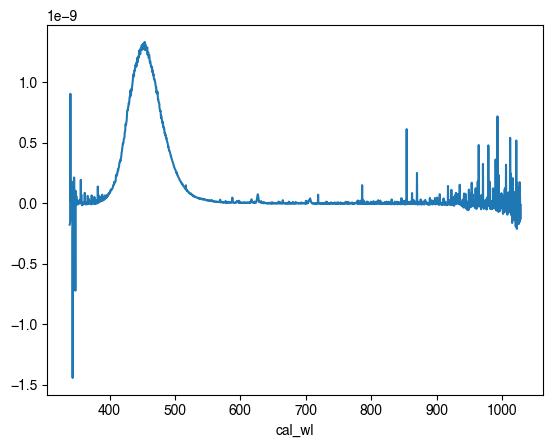

In [180]:
processed['blue'].plot()

In [168]:
from scipy.interpolate import interp1d

wls = pd.read_csv('../../data/jaz/Ar_calibrated_wls.csv')
processed.columns = ['red', 'green', 'blue', 'white']
new_wls = np.arange(380, 781, 1)
new = processed.apply(lambda x: interp1d(x.index, x.values)(new_wls))

<AxesSubplot: >

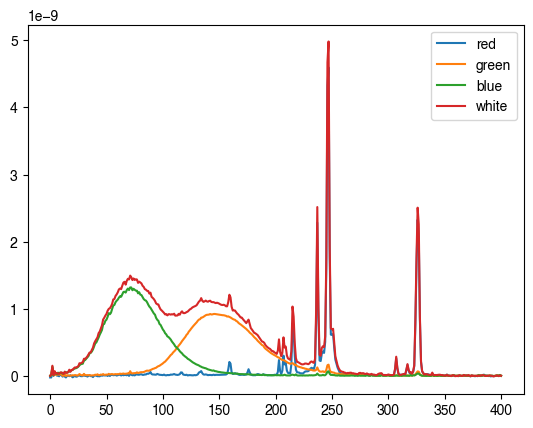

In [169]:
new.plot()

In [170]:
new.sum()

red      3.910454e-08
green    7.652609e-08
blue     8.242215e-08
white    2.105583e-07
dtype: float64